This is just to demonstrate how the analysis will work for the POC, and also to show what the final exported notebook will look like. When that is implemented, get rid of this!

First, generate a fake dataset. In the future, let's check it in and use it if the [`--demo` flag](https://github.com/opendp/dp-creator-ii/issues/7) is given.

In [194]:
import csv
import random

def clip(n, lower, upper):
    return max(min(n, upper), lower)

csv_path = '/tmp/demo.csv'

with open(csv_path, 'w', newline='') as demo_handle:
    fields = ['student_id', 'class_year', 'hw_number', 'grade']
    writer = csv.DictWriter(demo_handle, fieldnames=fields)
    writer.writeheader()
    for student_id in range(1, 50):
        class_year = int(clip(random.gauss(2, 1), 1, 4))
        mean_grade = random.gauss(80, 5) + class_year * 2
        for hw_number in range(1, 10):
            grade = int(clip(random.gauss(mean_grade, 5), 0, 100))
            writer.writerow({
                'student_id': student_id,
                'class_year': class_year,
                'hw_number': hw_number,
                'grade': grade,
            })

Sanity check:

In [195]:
import polars

lf = polars.scan_csv(csv_path)
lf.collect()

student_id,class_year,hw_number,grade
i64,i64,i64,i64
1,1,1,77
1,1,2,89
1,1,3,83
1,1,4,85
1,1,5,72
…,…,…,…
49,1,5,88
49,1,6,96
49,1,7,83


Plot function from in https://github.com/opendp/dp-creator-ii/pull/35: remove redundant def here when that is merged.

In [196]:
import matplotlib.pyplot as plt
import numpy as np


def plot_error_bars_with_cutoff(
    y_values, x_min_label="min", x_max_label="max", y_cutoff=0, y_error=0
):
    x_values = 0.5 + np.arange(len(y_values))
    x_values_above = []
    x_values_below = []
    y_values_above = []
    y_values_below = []
    for x, y in zip(x_values, y_values):
        if y < y_cutoff:
            x_values_below.append(x)
            y_values_below.append(y)
        else:
            x_values_above.append(x)
            y_values_above.append(y)

    figure, axes = plt.subplots()
    color = "skyblue"
    shared = {
        "width": 0.8,
        "edgecolor": color,
        "linewidth": 1,
        "yerr": y_error,
    }
    axes.bar(x_values_above, y_values_above, color=color, **shared)
    axes.bar(x_values_below, y_values_below, color="white", **shared)
    axes.hlines([y_cutoff], 0, len(y_values), colors=["black"], linestyles=["dotted"])

    axes.set(xlim=(0, len(y_values)), ylim=(0, max(y_values)))
    axes.get_xaxis().set_ticks(
        ticks=[x_values[0], x_values[-1]],
        labels=[x_min_label, x_max_label],
    )
    axes.get_yaxis().set_ticks([])

In [197]:
class_years = lf.group_by('class_year').len().collect().sort('class_year')
class_years

class_year,len
i64,u32
1,162
2,198
3,72
4,9


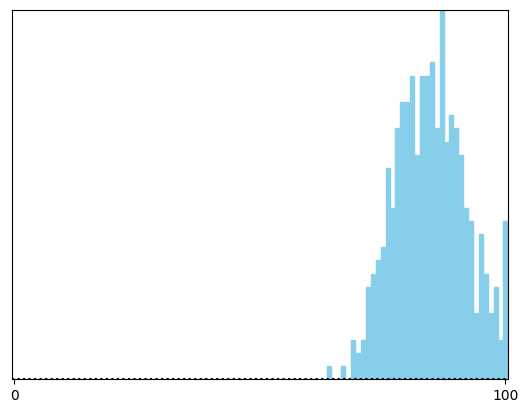

In [198]:
grades = lf.group_by('grade').len().collect().sort('grade')
min_grade = 0
max_grade = 100
df_0_100 = polars.from_dict({'grade': range(min_grade, max_grade+1)})
grades_0_100 = df_0_100.join(grades, on='grade', how='left').select(['len']).fill_null(0)
plot_error_bars_with_cutoff(grades_0_100.to_series().to_list(), min_grade, max_grade)

## _Proposed generated notebook starts below!_

---

# Introduction to Differential Privacy with OpenDP

This notebook will demonstrate how to make a differentially private release with [OpenDP](https://docs.opendp.org) using the data you've provided. The OpenDP API has many more options than we can expose in a UI, and this notebook will suggest some options to explore.

The concept of a privacy budget is important in DP. Interactively developing DP analyses is a good practice, for example, to identify variables of interest before choosing where to spend the rest of a finite privacy budget. That said, it is important to track the total budget consumed: It would not be good to run a cell in this notebook, look at output, and then run it again, without tracking the privacy consumed by each operaion.

We begin with a conventional set of imports and then define a [`Context`](https://docs.opendp.org/en/stable/api/user-guide/context/index.html), based on the information you provided:

In [199]:
# Uncomment if you have not already installed OpenDP:
# %pip install opendp==0.11.1

# OpenDP extends the Polars dataframe library:
import polars as pl
# Conventional import for OpenDP:
import opendp.prelude as dp

# OpenDP plans to offer a set algorithms that have been formally reviewed for correctness.
# Until that is complete, we need to opt-in to "contributed" features:
dp.enable_features("contrib")

In [200]:
# Information you've provided that applies to the whole calculation:
csv_path = '/tmp/demo.csv'
contributions = 10
epsilon = 2
weights = [1, 2]
max_possible_rows = 1000000 

# Information you've provided for the "grade" column:
grade_min = 50
grade_max = 100
grade_bins_count = 10

grade_bins_list = list(range(
    grade_min,
    grade_max,
    int((grade_max - grade_min) / grade_bins_count)
))

context = dp.Context.compositor(
    data=pl.scan_csv(csv_path, encoding="utf8-lossy").with_columns(
        pl.col("grade").cut(grade_bins_list).alias("grade_bin").cast(pl.String)
    ),
    privacy_unit=dp.unit_of(contributions=contributions),
    privacy_loss=dp.loss_of(epsilon=epsilon, delta=1e-7),
    split_by_weights=weights,
    margins={
        (): dp.polars.Margin(
            max_partition_length=max_possible_rows,
            # To calculate the mean, we need to know the total number of entries,
            # but this is not by default public information. We must opt-in:
            public_info="lengths",
        ),
        ("grade_bin",): dp.polars.Margin(
            max_partition_length=max_possible_rows,
            # To calculate the mean, we need to know the total number of entries,
            # but this is not by default public information. We must opt-in:
            public_info="keys",
        ),

    },
)

(A note on `utf8-lossy`: CSVs can use different "character encodings" to represent characters outside the plain ASCII character set, but out of the box the Polars library only supports UTF8. Specifying `utf8-lossy` preserves as much information as possible, and any unrecognized characters will be replaced by "�". If this is not sufficient, you will need to preprocess your data to reencode it as UTF8.)

In [201]:
grade_mean = context.query().select(
    pl.col("grade").fill_null(0).dp.mean(bounds=(grade_min, grade_max))
).release().collect()
grade_mean

grade
f64
84.011338


In [202]:
grade_histogram = (context.query()
        .group_by("grade_bin")
        .agg(pl.len().dp.noise())
        .release()
        .collect()
        .sort("grade_bin")
)
grade_histogram

grade_bin,len
str,u32
"""(60, 65]""",11
"""(65, 70]""",40
"""(70, 75]""",55
"""(75, 80]""",87
"""(80, 85]""",95
"""(85, 90]""",95
"""(90, 95]""",55
"""(95, inf]""",22
